# Installation

Install the necessary packages:
* Upgrade scikit-learn package.
* tensorflow-addons (Advanced tensors operations)
* tf-models-official (Pretrained models)
* dropbox (Cloud storage for the trained models)

Import the libs used in this notebook

In [ ]:
%%capture
!pip install -U scikit-learn
!pip install -U tensorflow-addons
!pip install -U tf-models-official
!pip install -U dropbox

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfpd
import tensorflow_addons as tfa
import tensorflow_hub as hub
import dropbox
import pickle

from tensorflow.keras import applications as apps
from tensorflow.keras import layers, optimizers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping
from official.vision.image_classification.augment import RandAugment

from os import path
from google.colab import files
from pathlib import Path
from time import time

# Dataset and metrics visualization

APIs:
* plot_dataset(ds, count, title): The default value of count is 4. The default value of title is 'dataset'.
* plot_acc(history): The history object is returned by the training function.
* plot_loss(history): The history object is returned by the training function.


## Dataset

In [ ]:
def title_color(label):
  color = 'black'

  if isinstance(label, np.ndarray):
    color = 'green' if label[0] == label[1] else 'red'

  return color

def plot_dataset(ds, count=4, title='dataset'):
  size = 4
  cols = 4
  rows = int((count+cols-1) / cols)

  ds_itr = ds.as_numpy_iterator()
  fig = plt.figure(figsize=(size*cols, size*rows))
  items = map(lambda id: (id,) + ds_itr.next(), range(count))

  for id, image, label in items:
    colid = id % cols
    rowid = id / cols

    ax = fig.add_subplot(rows, cols, id+1)

    ax.set_title(label, color=title_color(label))
    ax.imshow(image)
    ax.axis("off")
  
  fig.suptitle(title)
  plt.show()

## Metrics

In [ ]:
def plot_acc(history):
  val = history.history.get('val_accuracy')
  legend = ['train', 'val'] if val else ['train']

  plt.plot(history.history['accuracy'])
  if val: plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

def plot_loss(history, val=False):
  val = history.history.get('val_loss')
  legend = ['train', 'val'] if val else ['train']

  plt.plot(history.history['loss'])
  if val: plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

# Dataset creation

We use the *oxford_flowers102* to demonstrate the sample efficiency improvements. The dataset has integer class labels for the flower images. To identify the flowers by name, use the following links:
 * [Name=>Label](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1)
 * [Label=>Visual](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html) 

In this section, we create a **tf.data.Dataset** tensorflow object. We also create a small sample dataset for testing purposes. The dataset elements are formatted as a tuple *(image, class_label)*. We expose the following objects:
* train_prep_ds (Training dataset)
* val_prep_ds (Validation dataset)

In [ ]:
%%capture
(train_ds, val_ds), ds_info = tfds.load(
    'oxford_flowers102',
    with_info=True,
    split=['train', 'validation'],
    as_supervised=False,
    read_config=tfds.ReadConfig(try_autocache=False)
)

In [ ]:
# Dataset image size
IMG_SIZE = 264

def dsitem_to_tuple(item):
  return (item['image'], item['label'])

def resize_image(image, label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.cast(image, tf.uint8)
  return image, label

In [ ]:
train_ds = train_ds.map(dsitem_to_tuple).map(resize_image).cache()
val_ds = val_ds.map(dsitem_to_tuple).map(resize_image).cache()

In [ ]:
print(train_ds.as_numpy_iterator().next()[0].shape)
print(val_ds.as_numpy_iterator().next()[0].shape)

(264, 264, 3)
(264, 264, 3)


# Model architecture

We use a ResNet50 model pre-trained on the ImageNet dataset. The oxford_flowers102 is a small dataset with 1020 training images and 1020 validation images. Such a small sample is insufficient to train a model from scratch. However, with the pre-trained weights, this dataset is more than enough to achieve decent predictions. The model is exposed through a **model** variable. 

In [ ]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002
NUM_CLASSES = 102

def create_model():
  # Initalize the core model
  core_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
  core = apps.resnet50.ResNet50(**core_args)
  core.trainable = False

  # Setup the top
  model = tf.keras.Sequential([
    layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8),
    layers.Lambda(lambda x: tf.cast(x, tf.float32)),
    layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
    core,
    layers.Flatten(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  adam = optimizers.Adam(learning_rate=LEARNING_RATE)

  model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = create_model()
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 264, 264, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 264, 264, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 9, 9, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 165888)            0         
_________________________________________________________________
dropout (Dropout)            (None, 165888)            0         
_________________________________________________________________
dense (Dense)                (None, 102)               16920678  
Total params: 40,508,390
Trainable params: 16,920,678
Non

# Training Setup

In [ ]:
def train(model, tds, vds, batch_size=24, epochs=100):
  batch_tds = tds.shuffle(1000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
  batch_vds = vds.batch(256).prefetch(buffer_size=tf.data.AUTOTUNE)

  # Save the best weights during training
  checkpoint_name_tmpl = 'weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
  checkpoints = ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")

  history = model.fit(batch_tds, validation_data=batch_vds, epochs=epochs, callbacks=[checkpoints])

  return history

# Experiments

## baseline

Epoch 1/100
43/43 [==============================] - 77s 968ms/step - loss: 4.5983 - accuracy: 0.3833 - val_loss: 1.8394 - val_accuracy: 0.6833

Epoch 00001: val_accuracy improved from -inf to 0.68333, saving model to chkpt/weights-epoch-1-val_accuracy-0.6833.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
43/43 [==============================] - 21s 493ms/step - loss: 0.1100 - accuracy: 0.9784 - val_loss: 2.3430 - val_accuracy: 0.6745

Epoch 00002: val_accuracy did not improve from 0.68333
Epoch 3/100
43/43 [==============================] - 21s 495ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 2.1678 - val_accuracy: 0.6912

Epoch 00003: val_accuracy improved from 0.68333 to 0.69118, saving model to chkpt/weights-epoch-3-val_accuracy-0.6912.h5
Epoch 4/100
43/43 [==============================] - 21s 493ms/step - loss: 3.1883e-05 - accuracy: 1.0000 - val_loss: 2.1608 - val_accuracy: 0.6922

Epoch 00004: val_accuracy improved from 0.69118 to 0.69216, saving model to chkpt/weights-epoch-4-val_accuracy-0.6922.h5
Epoch 5/100
43/43 [==============================] - 21s 494ms/step - loss: 2.7181e-05 - accuracy: 1.0000 - val_loss: 2.1516 - val_accuracy: 0.6941

Epoch 00005: val_accuracy improved from 0.69216 to 0.69412, saving model to chkpt/weights-epoch-5-val_accuracy-0.69

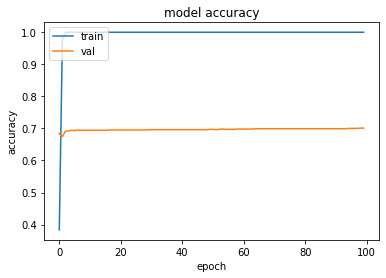

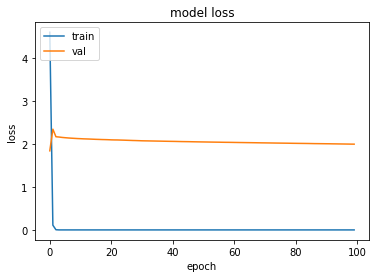

In [ ]:
baseline_hist = train(model, train_ds, val_ds, batch_size=24, epochs=100)

plot_acc(baseline_hist)
plot_loss(baseline_hist)

## basicaug-hflip-rotate-0.1

In [ ]:
augs = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
])

def augfn(image, label):
  image = tf.expand_dims(image, 0) # Introduce a batch dimension
  image = augs(image, training=True) # Apply augmentation
  image = tf.squeeze(image, axis=0) # Squeeze the batch
  return image, label

train_aug_ds = train_ds.map(augfn)

Epoch 1/100
43/43 [==============================] - 29s 502ms/step - loss: 14.9726 - accuracy: 0.3549 - val_loss: 12.6783 - val_accuracy: 0.5402

Epoch 00001: val_accuracy improved from -inf to 0.54020, saving model to chkpt/weights-epoch-1-val_accuracy-0.5402.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
43/43 [==============================] - 29s 500ms/step - loss: 2.5899 - accuracy: 0.8353 - val_loss: 6.2555 - val_accuracy: 0.6922

Epoch 00002: val_accuracy improved from 0.54020 to 0.69216, saving model to chkpt/weights-epoch-2-val_accuracy-0.6922.h5
Epoch 3/100
43/43 [==============================] - 29s 498ms/step - loss: 1.1365 - accuracy: 0.9186 - val_loss: 6.0117 - val_accuracy: 0.7020

Epoch 00003: val_accuracy improved from 0.69216 to 0.70196, saving model to chkpt/weights-epoch-3-val_accuracy-0.7020.h5
Epoch 4/100
43/43 [==============================] - 28s 497ms/step - loss: 0.7467 - accuracy: 0.9451 - val_loss: 5.5404 - val_accuracy: 0.7324

Epoch 00004: val_accuracy improved from 0.70196 to 0.73235, saving model to chkpt/weights-epoch-4-val_accuracy-0.7324.h5
Epoch 5/100
43/43 [==============================] - 28s 499ms/step - loss: 0.4817 - accuracy: 0.9588 - val_loss: 4.9102 - val_accuracy: 0.7412

Epoch 00005: val_accuracy improved from 0.73235 to 0.7411

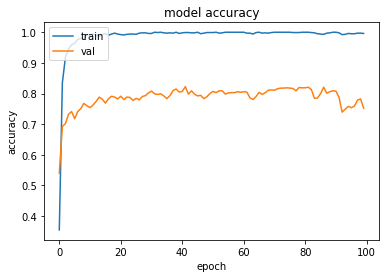

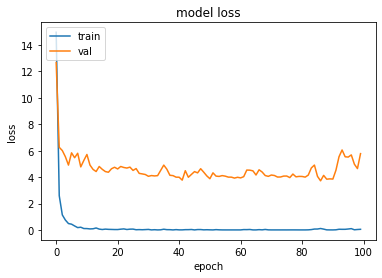

In [ ]:
augs_hist = train(model, train_aug_ds, val_ds, batch_size=24, epochs=100)

plot_acc(augs_hist)
plot_loss(augs_hist)